# SIR models

In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as spIntegrate
import matplotlib.pyplot as plt

This notebook shows and solved different versions of the SIR model.

# Classic SIR model

In [2]:
## Parameter definition
# Infection rate
rr = 0.0005
# Removal/recovery rate
a = 0.5
# Domain volume (only for stochastic)
Vol = 1.0
# Max integration time and max time steps
maxTime = 7.0
maxdt = 0.1
# Initial conditions
t0 = 0     # time
S0 = 5000  # suceptible
I0 = 100    # infected
R0 = 0
x0 = np.array([S0,I0,R0])

## Deterministic version

The SIR equations in a deterministic setting are the following:

$$
\begin{align*}
\frac{dS}{dt} &= -rSI \\ 
\frac{dI}{dt} &= rSI - aI \\
\frac{dR}{dt} &= aI
\end{align*}
$$

with $r$ the infection rate and $a$ the recovery rate. $S$, $I$ and $R$ are the number of suceptible, recovered and infected people, respectively.

In [3]:
# Right hand side of SIR ODE model
def deterministicSIR(t,x):
    S = x[0]
    I = x[1]
    R = x[2]
    y = np.zeros(3)
    y[0] = -rr*S*I
    y[1] = rr*S*I - a*I
    y[2] = a*I
    return y

In [4]:
# scipy Runge-Kutta 4 integrator
integrator = spIntegrate.RK45(deterministicSIR, t0, x0, maxTime, max_step = maxdt)

In [5]:
# integration up until maxTime
arrayTime = []; arrayS = []; arrayI = []; arrayR = []
dSdt = []; dIdt = []; dRdt = []
while integrator.t < maxTime:    
    integrator.step()
    arrayTime.append(integrator.t)
    arrayS.append(integrator.y[0])
    arrayI.append(integrator.y[1])
    arrayR.append(integrator.y[2])
    dydt = deterministicSIR(integrator.t, integrator.y) 
    dSdt.append(dydt[0])
    dIdt.append(dydt[1])
    dRdt.append(dydt[2])

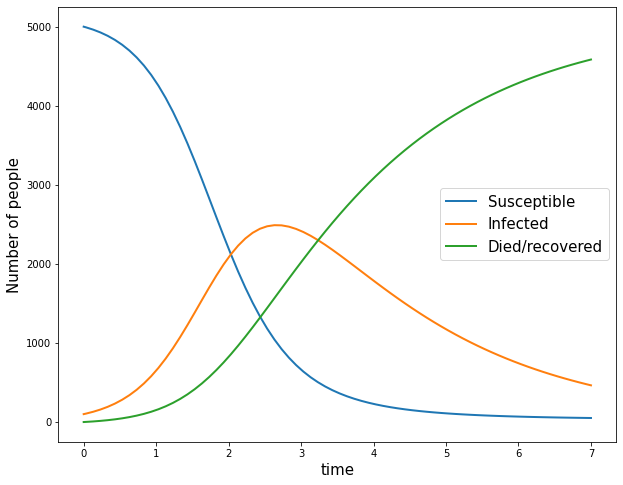

In [6]:
# Plot solution
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(arrayTime, arrayS, lw = 2, label = "Susceptible")
plt.plot(arrayTime, arrayI, lw = 2, label = "Infected")
plt.plot(arrayTime, arrayR, lw = 2, label = "Died/recovered")
plt.xlabel("time", fontsize = 15)
plt.ylabel("Number of people", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

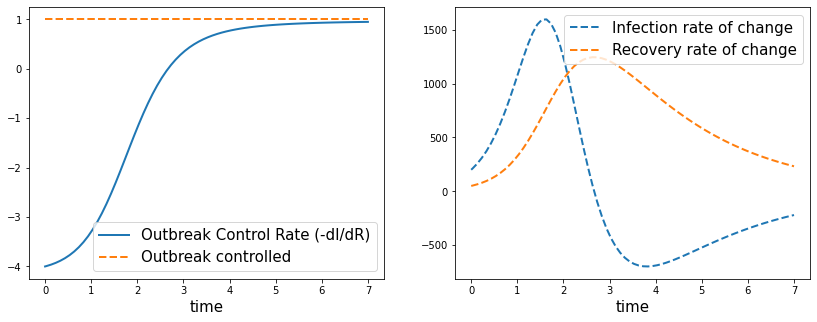

In [150]:
# Plot outbreak control rate
plt.rcParams["figure.figsize"] = (14,5)
fig, (ax1, ax2) = plt.subplots(1, 2)
outbreakControlRate = -np.array(dIdt)/np.array(dRdt)
ax1.plot(arrayTime, outbreakControlRate, lw = 2, label = "Outbreak Control Rate (-dI/dR)")
ax1.plot(arrayTime, np.ones(len(arrayTime)), lw = 2, ls = '--', label = "Outbreak controlled")
ax1.legend(fontsize = 15)
ax1.set_xlabel('time', fontsize = 15)
ax2.plot(arrayTime, dIdt, lw = 2, ls = '--', label = "Infection rate of change")
ax2.plot(arrayTime, dRdt, lw = 2, ls = '--', label = "Recovery rate of change")
ax2.legend(fontsize = 15)
ax2.set_xlabel('time', fontsize = 15)
plt.show()

## Stochastic version (Gillespie/master equation):

In [151]:
# Definition of Gillespie algorithm integration (specific for SIR)
def gillespieOneStep(time, St, It, Rt):
    infectionPropensity = rr*St*It/Vol
    recoveryPropensity = a*It/Vol
    lambda0 = infectionPropensity + recoveryPropensity
    # Calculate time for next reaction
    rand1 = np.random.rand()
    dtime = np.log(1.0 / rand1) / lambda0;
    time += dtime
    # Calculate which reaction will happen
    rand2 = np.random.rand()
    if (rand2*lambda0 <= infectionPropensity):
        St -= 1
        It += 1
    else:
        It -= 1
        Rt += 1
    return time, St, It, Rt

In [152]:
# integration up until maxTime
stochTime = 0
stochS = S0; stochI = I0; stochR = R0
stochArrayTime = []; stochArrayS = []; stochArrayI = []; stochArrayR = []
while stochTime < maxTime:  
    stochTime, stochS, stochI, stochR = gillespieOneStep(stochTime, stochS, stochI, stochR)
    stochArrayTime.append(stochTime)
    stochArrayS.append(stochS)
    stochArrayI.append(stochI)
    stochArrayR.append(stochR)

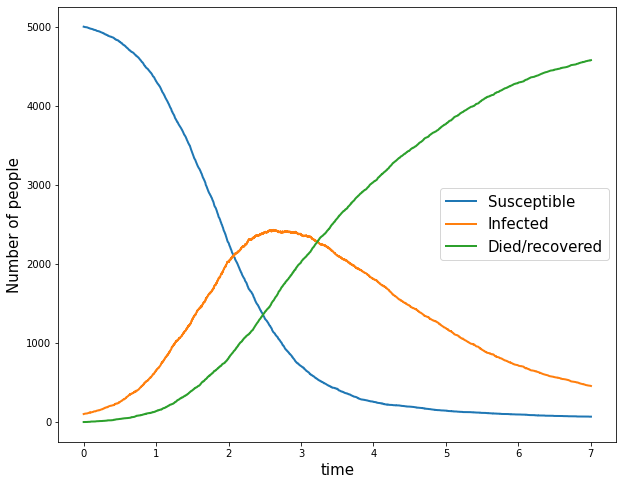

In [153]:
# Plot stochastic solution
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(stochArrayTime, stochArrayS, lw = 2, label = "Susceptible")
plt.plot(stochArrayTime, stochArrayI, lw = 2, label = "Infected")
plt.plot(stochArrayTime, stochArrayR, lw = 2, label = "Died/recovered")
plt.xlabel("time", fontsize = 15)
plt.ylabel("Number of people", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

# A simple bi-stable SIR model

In [154]:
## Parameter definition
# Infection rate
rrB = 0.0000005
# Removal/recovery rate
aB = 0.5
# Domain volume (only for stochastic)
VolB = 1.0
# Max integration time and max time steps
maxTimeB = 10.0
maxdtB = 0.1
# Initial conditions
t0B = 0       # time
S0B = 5000    # suceptible
I0B = 400     # infected
I0BAlt = 150  # infected alternate initial condition
R0B = 0
x0B = np.array([S0B,I0B,R0B])
x0BAlt = np.array([S0B,I0BAlt,R0B])

## Deterministic version

A modified version of the SIR model that yield a ''bistable'' behavior is:

$$
\begin{align*}
\frac{dS}{dt} &= -rSI^2 \\ 
\frac{dI}{dt} &= rSI^2 - aI \\
\frac{dR}{dt} &= aI
\end{align*}
$$

In [155]:
# Right hand side of SIR bistable ODE model
def deterministicBistableSIR(t,x):
    S = x[0]
    I = x[1]
    R = x[2]
    y = np.zeros(3)
    y[0] = -rrB*S*I*I
    y[1] = rrB*S*I*I - aB*I
    y[2] = aB*I
    return y

In [156]:
# scipy Runge-Kutta 4 integratoraAlt
integratorB = spIntegrate.RK45(deterministicBistableSIR, t0B, x0B, maxTimeB, max_step = maxdtB)
integratorBAlt = spIntegrate.RK45(deterministicBistableSIR, t0B, x0BAlt, maxTimeB, max_step = maxdtB)

In [157]:
# integration up until maxTime
arrayTimeB = []; arraySB = []; arrayIB = []; arrayRB = []
# Integrate systems
while integratorB.t < maxTimeB:    
    integratorB.step()
    arrayTimeB.append(integratorB.t)
    arraySB.append(integratorB.y[0])
    arrayIB.append(integratorB.y[1])
    arrayRB.append(integratorB.y[2])
    
# Integrate system with alternate initial condition
arrayTimeBAlt = []; arraySBAlt = []; arrayIBAlt = []; arrayRBAlt = []
while integratorBAlt.t < maxTimeB:    
    integratorBAlt.step()
    arrayTimeBAlt.append(integratorBAlt.t)
    arraySBAlt.append(integratorBAlt.y[0])
    arrayIBAlt.append(integratorBAlt.y[1])
    arrayRBAlt.append(integratorBAlt.y[2])

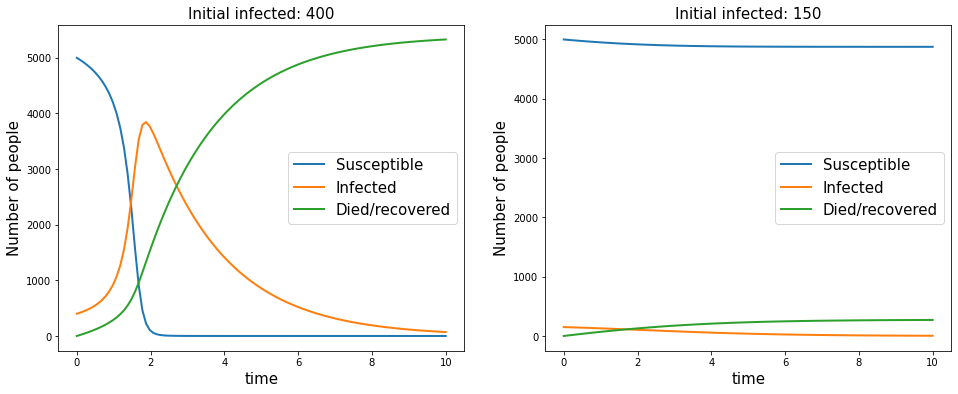

In [133]:
# Setup plot
plt.rcParams["figure.figsize"] = (16,6)
fig, (ax1, ax2) = plt.subplots(1, 2)
# Plot solution
ax1.plot(arrayTimeB, arraySB, lw = 2, label = "Susceptible")
ax1.plot(arrayTimeB, arrayIB, lw = 2, label = "Infected")
ax1.plot(arrayTimeB, arrayRB, lw = 2, label = "Died/recovered")
ax1.set_title("Initial infected: 400", fontsize = 15)
ax1.set_xlabel("time", fontsize = 15)
ax1.set_ylabel("Number of people", fontsize = 15)
ax1.legend(fontsize = 15)
# Plot alternate solution
ax2.plot(arrayTimeBAlt, arraySBAlt, lw = 2, label = "Susceptible")
ax2.plot(arrayTimeBAlt, arrayIBAlt, lw = 2, label = "Infected")
ax2.plot(arrayTimeBAlt, arrayRBAlt, lw = 2, label = "Died/recovered")
ax2.set_title("Initial infected: 150", fontsize = 15)
ax2.set_xlabel("time", fontsize = 15)
ax2.set_ylabel("Number of people", fontsize = 15)
ax2.legend(fontsize = 15)

plt.show()

## Stochastic version (work in progress ...)

# Variation of SIR with periodicity and open setting (use nonlinear incidence functions and add births and deaths)